In [13]:
%env NUMBA_CUDA_LOW_OCCUPANCY_WARNINGS=0
import torch
import numba.cuda as cu
import matplotlib.pyplot as plt

env: NUMBA_CUDA_LOW_OCCUPANCY_WARNINGS=0


# 计算HashGrid

$x$为输入，$x_i$为二维空间中的一个点，后文中将称这个点为“元素”。

tensor([[0.9000, 0.3000],
        [1.6000, 1.4000],
        [0.1000, 0.8000],
        [1.1000, 0.9000]])


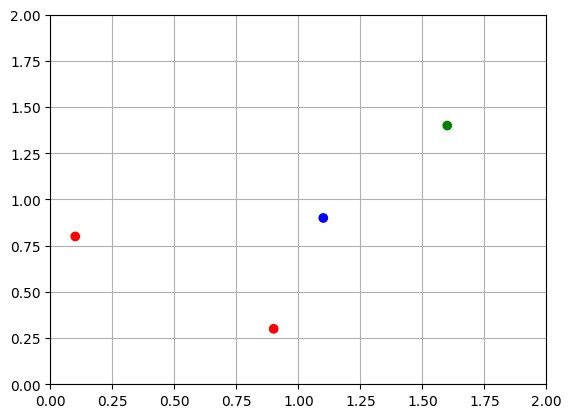

In [14]:
x = torch.tensor([
	[0.9, 0.3],
	[1.6, 1.4],
	[0.1, 0.8],
	[1.1, 0.9],
])

print(x)
plt.grid()
plt.axis([0, 2, 0, 2])
plt.scatter(x[:, 0], x[:, 1], color=['r', 'g', 'r', 'b'])
plt.show()

$\delta$为HashGrid的大小，也就是xy各维度有多少个格子。

In [15]:
delta = torch.tensor([2,2])
delta

tensor([2, 2])

$h$为HashGrid中格子的尺寸，每个格子占据了空间中$h\times h$大小的面积。

In [16]:
h = torch.tensor([1,1])
h

tensor([1, 1])

$H(x) = \lfloor \frac{x}{h} \rfloor \mod \delta$为哈希函数，从二维空间坐标映射到格子索引：$R^2 \rightarrow N^2$。

In [17]:
def H(x, h, delta):
	# Spatial Hash
	u = torch.floor(x/h) % delta
	return u
u = H(x, h, delta)

u

tensor([[0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 0.]])

因为pytorch的`sort`不接受多维tensor作为key，
所以在哈希后还得先把格子索引压缩为0维标量。

例如，当HashGrid尺寸为$\delta = (2,3,3)$，格子索引$u=(1,0,2)$时，
压缩后的索引为$1\times 3 \times 3 + 0 \times 3 + 2 \times 1 = 11$。

具体求值时，设$\bar{\delta}$为$\delta$的前缀积，即$\bar{\delta}_i = \prod^{i}_{j=1} \delta_j$。
并设共有$n$个维度，则压缩后的索引（使用broadcast传播$\bar{\delta}_n$）：

$$

\hat{u} = u \cdot \frac{\bar{\delta}_n}{\bar{\delta}}

$$

In [18]:
def squeeze_grid_index(u, delta):
	cumprod_delta = torch.cumprod(delta, dim=0)
	prodsum_delta = cumprod_delta[-1]
	d = torch.tensordot(u, prodsum_delta / cumprod_delta, dims=([1], [0])).int()
	return d
u = squeeze_grid_index(u, delta)

u

tensor([0, 3, 0, 2], dtype=torch.int32)

按照格子索引$u$进行排序，得到排序后的格子索引$s$，并有全排列$t$使得：

$$
s_i = u_{t_i}
$$

In [19]:
t = torch.argsort(u)

t

tensor([0, 2, 3, 1])

In [20]:
s = u[t]

s

tensor([0, 0, 2, 3], dtype=torch.int32)

构造索引矩阵$L, R$，使得第$i$个格子中包含的元素的索引集合$\Omega_i$为：

$$
\Omega_i = \{ j : j=t_i, i \in [L_i, R_i) \}
$$

也就是$L, R$分别标记了$s$中连续子数组的起始和结尾，
而因为$s$中存储的是（排序后的）格子索引，
所以每对$L_i, R_i$标记了格子索引为$i$的格子中的所有元素在$s$中的位置，
随后我们再通过$s_i = u_{t_i}$的关系映射回原来的元素索引$j$，最后得到元素值$x_j$。

这两个矩阵的数学表示为：

$$
\begin{aligned}

	&\left\{
	\begin{aligned}
		L_{u_i} &= \min \{ j : s_i = s_j \} \\
		L_{k} &= 0, \forall k: \forall i, k \neq u_i
	\end{aligned}
	\right.
	\\

	&\left\{
	\begin{aligned}
		R_{u_i} &= \max \{ j+1 : s_i = s_j \} \\
		R_{k} &= 0, \forall k: \forall i, k \neq u_i
	\end{aligned}
	\right.

\end{aligned}
$$

不过实际计算$L$的时候我们是对$s$写了一个kernel，使得对$s$的每个元素$s_i$：
* 若$i = 0$或$s_i = s_{i-1}$，则说明它是$s$中一个连续子数组的起始，于是把它填入$L$中：$L_{s_i} = i$
* 否则，什么也不做

对$R$也是同理。

In [21]:
# Convenient function for specifying CUDA thread block size
block_size = 32
def cal_block_num(n):
	return int((n-1)/block_size) + 1

In [22]:
@cu.jit
def cal_L(L, s):
	si = cu.grid(1)
	if si >= s.shape[0]:
		return
	if si == 0 or s[si] != s[si-1]:
		L[s[si]] = si

L = torch.zeros(size=[torch.prod(delta)]).int().cuda()
cal_L[cal_block_num(s.shape[0]), block_size](L, s.to(device="cuda"))
L

tensor([0, 0, 2, 3], device='cuda:0', dtype=torch.int32)

In [23]:
@cu.jit
def cal_R(R, s):
	si = cu.grid(1)
	if si >= s.shape[0]:
		return
	if si == s.shape[0]-1 or s[si] != s[si+1]:
		R[s[si]] = si+1

R = torch.zeros(size=[torch.prod(delta)]).int().cuda()
cal_R[cal_block_num(s.shape[0]), block_size](R, s.to(device="cuda"))
R

tensor([2, 0, 3, 4], device='cuda:0', dtype=torch.int32)

**TODO: 把$t$消掉，让$L,R$指向的数组直接就是存放着粒子的原始索引**

# 使用HashGrid

为了方便验证HashGrid，我们设计了一个简单的问题——

为每个元素赋予一个权重值$v$（即，对每个$x_i$都有一个$v_i$），欲求$r$使得$r_i$等于元素$x_i$所在格子中的所有元素的权重值的总和（包括$x_i$自己），即：

$$
r_i = \sum_{j \in \Omega_k} v_j
$$

其中$k$为$x_i$所在格子的索引，$\Omega_k$为该格子包含的所有元素的索引。

In [24]:
v = torch.tensor([2,3,5,7])

如果是串行实现的话，那$r$的计算方法大概就是如下的二重循环（第0个和第2个是在同一个格子里，所以$r_0 = r_2 = 2 + 5 = 7$）：

In [49]:
r = torch.zeros_like(v)
for ui in range(0, len(r)):
	cell_id = u[ui]
	for si in range(L[cell_id], R[cell_id]):
		vi = t[si]
		r[ui] += v[vi]

r

tensor([7, 3, 7, 7])

不过注意到上面的二重循环的内层循环是一个不定长循环，
就是说对不同的`ui`而言，内层循环的迭代次数$R_{u_i} - L_{u_i}$也是不同的。

这就导致该循环没法在GPU跑（或者说如果强行在GPU上跑的话容易出现效率很低的情况，具体原因此处不做展开）。
因此我们需要把它展开成定长循环才行。

## 不定长循环展开

注意到上面的二重循环其实可以看成是对一个二维不规则数组$C$的遍历，
数组元素$C_{ij}$为：

$$
	C_{ij} = (r_i, v_{t_j})
$$

此处略去关于展开二维不规则数组的讨论（TODO：给出一个博客链接）

我们首先计算内层循环的迭代次数，并将其存储到$S$中，即$S_i = R_{u_i} - L_{u_i}$：

In [30]:
@cu.jit
def cal_S(S, L, R, u):
	i = cu.grid(1)
	if i >= S.shape[0]:
		return
	j = u[i]
	S[i] = R[j] - L[j]

S = torch.empty_like(v, dtype=int).cuda()
cal_S[cal_block_num(S.shape[0]), block_size](S, L.cuda(), R.cuda(), u.cuda())

S

tensor([2, 1, 2, 1], device='cuda:0')

In [38]:
total_loop_num = torch.sum(S).item()
total_loop_num

6

In [39]:
W = S.cumsum(0).roll(1, 0)
W[0] = 0

W

tensor([0, 2, 3, 5], device='cuda:0')

In [40]:
from flood import rightflood

In [46]:
I: torch.Tensor = torch.zeros(total_loop_num, dtype=torch.long).cuda()
I.index_add_(dim=0, index=W.cuda(), source=torch.arange(start=0, end=W.shape[0]).cuda(), alpha=1)
I = rightflood(I)

I

tensor([0, 0, 1, 2, 2, 3], device='cuda:0')

In [48]:
S: torch.Tensor = torch.zeros(total_loop_num, dtype=torch.long).cuda()
S.index_add_(dim=0, index=W.cuda(), source=W.cuda(), alpha=1)
S = rightflood(S)

S

tensor([0, 0, 2, 3, 3, 5], device='cuda:0')

In [53]:
@cu.jit
def traverse(r, v, t, u, L, I, S):
	k = cu.grid(1)
	if k >= I.shape[0]:
		return
	i = I[k]
	j = k - S[k]
	vi = t[j + L[u[i]]]
	cu.atomic.add(r, i, v[vi])
	
r = torch.zeros_like(v).cuda()
traverse[cal_block_num(I.shape[0]), block_size](r, v.cuda(), t.cuda(), u.cuda(), L.cuda(), I, S)

r

tensor([7, 3, 7, 7], device='cuda:0')